### Recolección de datos en twitter

In [1]:
!pip install tweepy


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import tweepy
import re
import regex
import emoji

import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)
import seaborn as sns

from collections import Counter

from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from flair.models import TextClassifier
from flair.data import Sentence

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

from nltk.corpus import stopwords
stopwords = stopwords.words('spanish')
import PIL.Image
from IPython.display import display

In [3]:
# Leer llaves
#keys = pd.read_csv("API_Tweter.csv", header=None, sep = '\t')

#keys = dict(zip(keys[0],keys[1]))

In [4]:
# Autorizar a través API
#auth = tweepy.OAuthHandler(keys['API_key'], keys['API_secret'])
#auth.set_access_token(keys['Access token'], keys['Access token secret'])
#api = tweepy.API(auth, wait_on_rate_limit=True)

In [10]:
# Recolección de datos
tweets = tweepy.Cursor(api.search,
                       q=['chatGPT -RT'],
                       lang='es',
                       geocode=f'4.60971,-74.08175,2000mi',
                       tweet_mode='extended',
                       include_rts=False).items(1000)

In [11]:
tweets

In [12]:
t = []

for tweet in tweets:
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
    temp.append(tweet.user.location)
    temp.append(tweet.coordinates)
    temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
    
    t.append(temp)

In [13]:
t;

In [14]:
dataGPT = pd.DataFrame(t)
dataGPT.columns = ['tweet', 'date', 'user_location', 'coordinates','link']
dataGPT.head()

,tweet,date,user_location,coordinates,link
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...


In [15]:
dataGPT.to_csv("dataGPT.csv", index=False)

In [16]:
dataGPT.tweet.count()

1000

#### Limpiar links, menciones y hashtagas

In [17]:
import re 
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweet']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
             
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")
        
    return text, links, hashtags, mentions

In [29]:
dataGPT[['clean', 'links', 'hashtags', 'mentions']] = dataGPT.apply(text_clean, axis=1, result_type='expand')

dataGPT.head()


,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],El inesperado milagro de crece más rápido que...
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],La batalla de los bots transformará la forma c...
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],"LLaMA, el nuevo modelo de lenguaje de Intelige..."
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],Qué increíble e interesante es el 🤯
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],Ambas herramientas ofrecen respuestas a pregu...


In [30]:
import regex
import emoji
 
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
 
    return emoji_list
 
dataGPT['emojis'] = dataGPT['clean'].apply(lambda text: get_emojis(text))
dataGPT.head()

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[]
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[]
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[]
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯]
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]"


### Limpiar emojis

In [31]:
import regex
import emoji

def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

dataGPT['emojis'] = dataGPT['clean'].apply(lambda text: get_emojis(text))

In [32]:
dataGPT

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[]
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[]
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[]
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯]
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]"
...,...,...,...,...,...,...,...,...,...,...
995,Baidu lanza Ernie Bot para competir con ChatGP...,2023-02-23 21:00:06,Venezuela,None,https://twitter.com/i/web/status/1628862286558...,Baidu lanza Ernie Bot para competir con ChatGPT,[https://t.co/ic8XrEOeR0],[],[],[]
996,¿Te imaginaste que un juez realice una audienc...,2023-02-23 20:57:36,"Lima, Peru",None,https://twitter.com/i/web/status/1628861658285...,¿Te imaginaste que un juez realice una audienc...,[https://t.co/oNfUuwEhG8],[],[],[🤖]
997,Microsoft incluye publicidad en las respuestas...,2023-02-23 20:57:01,Ciudad de México,None,https://twitter.com/i/web/status/1628861509559...,Microsoft incluye publicidad en las respuestas...,[https://t.co/ZbrhqHKALK],[#Tecnología],[@Mkt4eCommerceMX],[]
998,Lo que ustedes no saben es que los tuits de la...,2023-02-23 20:53:56,"Cali, Colombia",None,https://twitter.com/i/web/status/1628860734229...,Lo que ustedes no saben es que los tuits de la...,[],[],[],[🙏🏻]


In [60]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [61]:
dataGPT['sinemojis'] = dataGPT['clean'].apply(lambda text: deEmojify(text))
dataGPT

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,sinemojis,preprocesado,lema,fecha,conteo
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[],El inesperado milagro de crece más rápido que...,inesperado milagro crece rápido cuenta cientos...,"[inesperado, milagro, crece, rápido, cuenta, c...",2023-02-25,17
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[],La batalla de los bots transformará la forma c...,batalla bots transformará forma personas encue...,"[batalla, bot, transformará, forma, persona, e...",2023-02-25,23
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[],"LLaMA, el nuevo modelo de lenguaje de Intelige...",llama nuevo modelo lenguaje inteligencia artif...,"[llama, nuevo, modelo, lenguaje, inteligencia,...",2023-02-25,15
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯],Qué increíble e interesante es el 🤯,increíble interesante,"[increíble, interesante]",2023-02-25,7
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]",Ambas herramientas ofrecen respuestas a pregu...,ambas herramientas ofrecen respuestas pregunta...,"[ambas, herramientas, ofrecen, respuestas, pre...",2023-02-25,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Baidu lanza Ernie Bot para competir con ChatGP...,2023-02-23 21:00:06,Venezuela,None,https://twitter.com/i/web/status/1628862286558...,Baidu lanza Ernie Bot para competir con ChatGPT,[https://t.co/ic8XrEOeR0],[],[],[],Baidu lanza Ernie Bot para competir con ChatGPT,baidu lanza ernie bot competir chatgpt,"[baidu, lanza, ernie, bot, competir, chatgpt]",2023-02-23,8
996,¿Te imaginaste que un juez realice una audienc...,2023-02-23 20:57:36,"Lima, Peru",None,https://twitter.com/i/web/status/1628861658285...,¿Te imaginaste que un juez realice una audienc...,[https://t.co/oNfUuwEhG8],[],[],[🤖],¿Te imaginaste que un juez realice una audienc...,imaginaste juez realice audiencia metaverso us...,"[imaginaste, juez, realice, audiencia, metaver...",2023-02-23,19
997,Microsoft incluye publicidad en las respuestas...,2023-02-23 20:57:01,Ciudad de México,None,https://twitter.com/i/web/status/1628861509559...,Microsoft incluye publicidad en las respuestas...,[https://t.co/ZbrhqHKALK],[#Tecnología],[@Mkt4eCommerceMX],[],Microsoft incluye publicidad en las respuestas...,microsoft incluye publicidad respuestas creada...,"[microsoft, incluye, publicidad, respuestas, c...",2023-02-23,13
998,Lo que ustedes no saben es que los tuits de la...,2023-02-23 20:53:56,"Cali, Colombia",None,https://twitter.com/i/web/status/1628860734229...,Lo que ustedes no saben es que los tuits de la...,[],[],[],[🙏🏻],Lo que ustedes no saben es que los tuits de la...,ustedes saben tuits maluca carolina sanín escr...,"[ustedes, saben, tuits, maluca, carolina, saní...",2023-02-23,24


In [62]:
dataGPT.to_csv("dataGPT2.csv", index=False)

In [35]:
import re

from nltk.corpus import stopwords
stopwords = stopwords.words('spanish')

from nltk.stem.snowball import SnowballStemmer
spanishStemmer=SnowballStemmer("spanish")

import nltk 
from nltk.stem import WordNetLemmatizer 
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

In [36]:
stopwords.append("openAI")
stopwords.append("open")
stopwords.append("AI")
stopwords.append("OpenAI")
stopwords.append("API")
stopwords.append("uso")
stopwords.append("usar")
stopwords.append("openai")
stopwords.append("herramienta")
stopwords.append("cahtGPT")
stopwords.append("cahtgpt")
stopwords.append("ia")
stopwords.append("si")
stopwords.append("cómo")
stopwords.append("ser")
stopwords.append("ai")
stopwords.append("través")
stopwords.append("\n")

In [37]:
def preprocesotext(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join(palabra for palabra in texto.split() if palabra not in stopwords)
    return texto

In [38]:
dataGPT['preprocesado'] = dataGPT['clean'].apply(lambda fila: preprocesotext(fila)) 
dataGPT.head()

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,sinemojis,preprocesado
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[],El inesperado milagro de crece más rápido que...,inesperado milagro crece rápido cuenta cientos...
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[],La batalla de los bots transformará la forma c...,batalla bots transformará forma personas encue...
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[],"LLaMA, el nuevo modelo de lenguaje de Intelige...",llama nuevo modelo lenguaje inteligencia artif...
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯],Qué increíble e interesante es el 🤯,increíble interesante
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]",Ambas herramientas ofrecen respuestas a pregu...,ambas herramientas ofrecen respuestas pregunta...


In [39]:
def lema(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = [lemmatizer.lemmatize(palabra) for palabra in texto.split() if palabra not in stopwords]
    return texto

In [40]:
dataGPT['lema'] = dataGPT['clean'].apply(lambda fila: lema(fila)) 
dataGPT.head()

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,sinemojis,preprocesado,lema
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[],El inesperado milagro de crece más rápido que...,inesperado milagro crece rápido cuenta cientos...,"[inesperado, milagro, crece, rápido, cuenta, c..."
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[],La batalla de los bots transformará la forma c...,batalla bots transformará forma personas encue...,"[batalla, bot, transformará, forma, persona, e..."
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[],"LLaMA, el nuevo modelo de lenguaje de Intelige...",llama nuevo modelo lenguaje inteligencia artif...,"[llama, nuevo, modelo, lenguaje, inteligencia,..."
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯],Qué increíble e interesante es el 🤯,increíble interesante,"[increíble, interesante]"
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]",Ambas herramientas ofrecen respuestas a pregu...,ambas herramientas ofrecen respuestas pregunta...,"[ambas, herramientas, ofrecen, respuestas, pre..."


In [41]:
dataGPT.to_excel("dataGPTClean.xls", index=False)

In [42]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
 
import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

In [43]:
import regex
import emoji

def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

dataGPT['emojis'] = dataGPT['clean'].apply(lambda text: get_emojis(text))

In [44]:
dataGPT.head()

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,sinemojis,preprocesado,lema
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[],El inesperado milagro de crece más rápido que...,inesperado milagro crece rápido cuenta cientos...,"[inesperado, milagro, crece, rápido, cuenta, c..."
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[],La batalla de los bots transformará la forma c...,batalla bots transformará forma personas encue...,"[batalla, bot, transformará, forma, persona, e..."
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[],"LLaMA, el nuevo modelo de lenguaje de Intelige...",llama nuevo modelo lenguaje inteligencia artif...,"[llama, nuevo, modelo, lenguaje, inteligencia,..."
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯],Qué increíble e interesante es el 🤯,increíble interesante,"[increíble, interesante]"
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]",Ambas herramientas ofrecen respuestas a pregu...,ambas herramientas ofrecen respuestas pregunta...,"[ambas, herramientas, ofrecen, respuestas, pre..."


In [45]:
from collections import Counter

temp_emojis = pd.DataFrame(list(zip(Counter(sum(dataGPT.emojis.values,[])).keys(),Counter(sum(dataGPT.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cnt']
temp_emojis.sort_values('cnt', ascending=False, inplace=True)
temp_emojis.head(20)

,emoji,cnt
12,🤖,25
7,🤣,20
33,😂,19
3,👇,15
2,🤔,13
25,➡️,11
0,🤯,10
30,💬,9
23,⬇️,9
66,😍,9


In [46]:
dataGPT['fecha']= dataGPT.date.dt.date
tiempo=pd.DataFrame(dataGPT.fecha.value_counts()).reset_index()
tiempo.columns= ['fecha', 'cnt']
tiempo= tiempo.sort_values('fecha')
tiempo

,fecha,cnt
2,2023-02-23,92
0,2023-02-24,568
1,2023-02-25,340


In [47]:
import re
import pandas as pd
import numpy as np

In [48]:
dataGPT['conteo'] = dataGPT['clean'].apply(lambda fila:len(fila.split()))

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
count_vect = CountVectorizer()
bow_rep = count_vect.fit_transform(dataGPT['clean'].values)
dataGPT

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,sinemojis,preprocesado,lema,fecha,conteo
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",None,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,[https://t.co/MfrsUH8IQf],"[#ChatGPT:, #TikTok]",[],[],El inesperado milagro de crece más rápido que...,inesperado milagro crece rápido cuenta cientos...,"[inesperado, milagro, crece, rápido, cuenta, c...",2023-02-25,17
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",None,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,[https://t.co/auZ4NpqDdH],"[#buscadores., #chatgpt, #google, #inteligenci...",[],[],La batalla de los bots transformará la forma c...,batalla bots transformará forma personas encue...,"[batalla, bot, transformará, forma, persona, e...",2023-02-25,23
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,None,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","[https://t.co/12nxKa6lcR, https://t.co/ti9j2lb...",[],[],[],"LLaMA, el nuevo modelo de lenguaje de Intelige...",llama nuevo modelo lenguaje inteligencia artif...,"[llama, nuevo, modelo, lenguaje, inteligencia,...",2023-02-25,15
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",None,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],[#ChatGPT],[],[🤯],Qué increíble e interesante es el 🤯,increíble interesante,"[increíble, interesante]",2023-02-25,7
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",None,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,[https://t.co/4kiwV3eE9l],[#ChatGPT],[@StackOverflow],"[💻, 🤔, 👇]",Ambas herramientas ofrecen respuestas a pregu...,ambas herramientas ofrecen respuestas pregunta...,"[ambas, herramientas, ofrecen, respuestas, pre...",2023-02-25,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Baidu lanza Ernie Bot para competir con ChatGP...,2023-02-23 21:00:06,Venezuela,None,https://twitter.com/i/web/status/1628862286558...,Baidu lanza Ernie Bot para competir con ChatGPT,[https://t.co/ic8XrEOeR0],[],[],[],Baidu lanza Ernie Bot para competir con ChatGPT,baidu lanza ernie bot competir chatgpt,"[baidu, lanza, ernie, bot, competir, chatgpt]",2023-02-23,8
996,¿Te imaginaste que un juez realice una audienc...,2023-02-23 20:57:36,"Lima, Peru",None,https://twitter.com/i/web/status/1628861658285...,¿Te imaginaste que un juez realice una audienc...,[https://t.co/oNfUuwEhG8],[],[],[🤖],¿Te imaginaste que un juez realice una audienc...,imaginaste juez realice audiencia metaverso us...,"[imaginaste, juez, realice, audiencia, metaver...",2023-02-23,19
997,Microsoft incluye publicidad en las respuestas...,2023-02-23 20:57:01,Ciudad de México,None,https://twitter.com/i/web/status/1628861509559...,Microsoft incluye publicidad en las respuestas...,[https://t.co/ZbrhqHKALK],[#Tecnología],[@Mkt4eCommerceMX],[],Microsoft incluye publicidad en las respuestas...,microsoft incluye publicidad respuestas creada...,"[microsoft, incluye, publicidad, respuestas, c...",2023-02-23,13
998,Lo que ustedes no saben es que los tuits de la...,2023-02-23 20:53:56,"Cali, Colombia",None,https://twitter.com/i/web/status/1628860734229...,Lo que ustedes no saben es que los tuits de la...,[],[],[],[🙏🏻],Lo que ustedes no saben es que los tuits de la...,ustedes saben tuits maluca carolina sanín escr...,"[ustedes, saben, tuits, maluca, carolina, saní...",2023-02-23,24


In [51]:
from collections import Counter

words = pd.DataFrame(list(zip(Counter(sum(dataGPT.lema.values,[])).keys(),Counter(sum(dataGPT.lema.values,[])).values())))
words.columns = ['word', 'cnt']
words.sort_values('cnt', ascending=False, inplace=True)
salida=words.head(15)
salida

,word,cnt
26,chatgpt,777
23,inteligencia,122
24,artificial,120
138,microsoft,59
40,puede,56
90,meta,48
20,nuevo,35
338,hace,33
92,propia,30
140,robot,30


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000242D91FC6C8>],
      dtype=object)

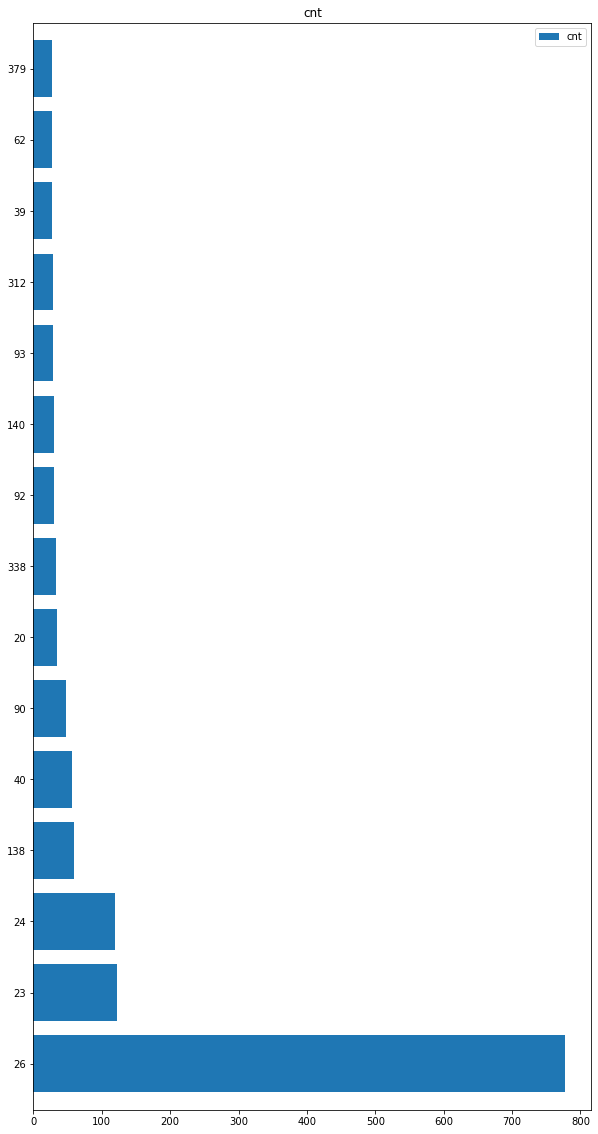

In [53]:
salida.plot(kind = 'barh',
             width=0.8,
             subplots=True,
             figsize=(10,20))

In [54]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)
from collections import Counter
trace = go.Bar(x=salida.word.values[:9],
               y=salida.cnt.values[:9])

layout = go.Layout(title='Palabras más usadas búsqueda CHATGPT')

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [55]:
data2= pd.read_excel("dataGPTClean.xls")
data2

,tweet,date,user_location,coordinates,link,clean,links,hashtags,mentions,emojis,sinemojis,preprocesado,lema
0,El inesperado milagro de #ChatGPT: crece más r...,2023-02-25 20:58:58,"Starbucks, clouds y Chimbote",NaN,https://twitter.com/i/web/status/1629586778708...,El inesperado milagro de crece más rápido que...,['https://t.co/MfrsUH8IQf'],"['#ChatGPT:', '#TikTok']",[],[],El inesperado milagro de crece más rápido que...,inesperado milagro crece rápido cuenta cientos...,"['inesperado', 'milagro', 'crece', 'rápido', '..."
1,La batalla de los bots transformará la forma c...,2023-02-25 20:56:49,"Miami, FL",NaN,https://twitter.com/i/web/status/1629586236481...,La batalla de los bots transformará la forma c...,['https://t.co/auZ4NpqDdH'],"['#buscadores.', '#chatgpt', '#google', '#inte...",[],[],La batalla de los bots transformará la forma c...,batalla bots transformará forma personas encue...,"['batalla', 'bot', 'transformará', 'forma', 'p..."
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",2023-02-25 20:52:03,Santa Cruz de la Sierra,NaN,https://twitter.com/i/web/status/1629585036872...,"LLaMA, el nuevo modelo de lenguaje de Intelige...","['https://t.co/12nxKa6lcR', 'https://t.co/ti9j...",[],[],[],"LLaMA, el nuevo modelo de lenguaje de Intelige...",llama nuevo modelo lenguaje inteligencia artif...,"['llama', 'nuevo', 'modelo', 'lenguaje', 'inte..."
3,Qué increíble e interesante es el #ChatGPT 🤯,2023-02-25 20:51:09,"San José, Costa Rica",NaN,https://twitter.com/i/web/status/1629584810338...,Qué increíble e interesante es el 🤯,[],['#ChatGPT'],[],['🤯'],Qué increíble e interesante es el 🤯,increíble interesante,"['increíble', 'interesante']"
4,💻 Ambas herramientas ofrecen respuestas a preg...,2023-02-25 20:47:35,"Mazatlán, Sinaloa",NaN,https://twitter.com/i/web/status/1629583914040...,💻 Ambas herramientas ofrecen respuestas a preg...,['https://t.co/4kiwV3eE9l'],['#ChatGPT'],['@StackOverflow'],"['💻', '🤔', '👇']",Ambas herramientas ofrecen respuestas a pregu...,ambas herramientas ofrecen respuestas pregunta...,"['ambas', 'herramientas', 'ofrecen', 'respuest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Baidu lanza Ernie Bot para competir con ChatGP...,2023-02-23 21:00:06,Venezuela,NaN,https://twitter.com/i/web/status/1628862286558...,Baidu lanza Ernie Bot para competir con ChatGPT,['https://t.co/ic8XrEOeR0'],[],[],[],Baidu lanza Ernie Bot para competir con ChatGPT,baidu lanza ernie bot competir chatgpt,"['baidu', 'lanza', 'ernie', 'bot', 'competir',..."
996,¿Te imaginaste que un juez realice una audienc...,2023-02-23 20:57:36,"Lima, Peru",NaN,https://twitter.com/i/web/status/1628861658285...,¿Te imaginaste que un juez realice una audienc...,['https://t.co/oNfUuwEhG8'],[],[],['🤖'],¿Te imaginaste que un juez realice una audienc...,imaginaste juez realice audiencia metaverso us...,"['imaginaste', 'juez', 'realice', 'audiencia',..."
997,Microsoft incluye publicidad en las respuestas...,2023-02-23 20:57:01,Ciudad de México,NaN,https://twitter.com/i/web/status/1628861509559...,Microsoft incluye publicidad en las respuestas...,['https://t.co/ZbrhqHKALK'],['#Tecnología'],['@Mkt4eCommerceMX'],[],Microsoft incluye publicidad en las respuestas...,microsoft incluye publicidad respuestas creada...,"['microsoft', 'incluye', 'publicidad', 'respue..."
998,Lo que ustedes no saben es que los tuits de la...,2023-02-23 20:53:56,"Cali, Colombia",NaN,https://twitter.com/i/web/status/1628860734229...,Lo que ustedes no saben es que los tuits de la...,[],[],[],['🙏🏻'],Lo que ustedes no saben es que los tuits de la...,ustedes saben tuits maluca carolina sanín escr...,"['ustedes', 'saben', 'tuits', 'maluca', 'carol..."


In [56]:
dfTweets=data2[['tweet', 'user_location', 'preprocesado', 'lema']]
dfTweets

,tweet,user_location,preprocesado,lema
0,El inesperado milagro de #ChatGPT: crece más r...,"Starbucks, clouds y Chimbote",inesperado milagro crece rápido cuenta cientos...,"['inesperado', 'milagro', 'crece', 'rápido', '..."
1,La batalla de los bots transformará la forma c...,"Miami, FL",batalla bots transformará forma personas encue...,"['batalla', 'bot', 'transformará', 'forma', 'p..."
2,"LLaMA, el nuevo modelo de lenguaje de Intelige...",Santa Cruz de la Sierra,llama nuevo modelo lenguaje inteligencia artif...,"['llama', 'nuevo', 'modelo', 'lenguaje', 'inte..."
3,Qué increíble e interesante es el #ChatGPT 🤯,"San José, Costa Rica",increíble interesante,"['increíble', 'interesante']"
4,💻 Ambas herramientas ofrecen respuestas a preg...,"Mazatlán, Sinaloa",ambas herramientas ofrecen respuestas pregunta...,"['ambas', 'herramientas', 'ofrecen', 'respuest..."
...,...,...,...,...
995,Baidu lanza Ernie Bot para competir con ChatGP...,Venezuela,baidu lanza ernie bot competir chatgpt,"['baidu', 'lanza', 'ernie', 'bot', 'competir',..."
996,¿Te imaginaste que un juez realice una audienc...,"Lima, Peru",imaginaste juez realice audiencia metaverso us...,"['imaginaste', 'juez', 'realice', 'audiencia',..."
997,Microsoft incluye publicidad en las respuestas...,Ciudad de México,microsoft incluye publicidad respuestas creada...,"['microsoft', 'incluye', 'publicidad', 'respue..."
998,Lo que ustedes no saben es que los tuits de la...,"Cali, Colombia",ustedes saben tuits maluca carolina sanín escr...,"['ustedes', 'saben', 'tuits', 'maluca', 'carol..."


In [57]:
#!pip install stanza

In [58]:
import stanza
stanza.download('es')

2023-02-25 16:21:09 INFO: Downloading default packages for language: es (Spanish) ...


2023-02-25 16:21:13 INFO: File exists: C:\Users\villa\stanza_resources\es\default.zip
2023-02-25 16:21:20 INFO: Finished downloading models and saved to C:\Users\villa\stanza_resources.


In [59]:
#nlp = stanza.Pipeline('es', processors='tokenize,pos')
#doc = nlp('yo estoy haciendo una prueba de la librería stanza')